### 모듈 임포트

In [67]:
from PIL import Image
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 

### 데이터셋 준비

In [68]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  

    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

In [69]:
s_image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data/scissors"
resize_images(s_image_dir_path)

print("가위 이미지 resize 완료!")

1694  images to be resized.
1694  images resized.
가위 이미지 resize 완료!


In [70]:
r_image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data/rock"
resize_images(r_image_dir_path)

print("바위 이미지 resize 완료!")

1805  images to be resized.
1805  images resized.
바위 이미지 resize 완료!


In [71]:
p_image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data/paper"
resize_images(p_image_dir_path)

print("보 이미지 resize 완료!")

1808  images to be resized.
1808  images resized.
보 이미지 resize 완료!


In [72]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [73]:
image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data"
(x_train, y_train)=load_data(image_dir_path, 5307)

학습데이터(x_train)의 이미지 개수는 5307 입니다.


In [74]:
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (5307, 28, 28, 3)
y_train shape: (5307,)


### 시각화

간단한 시각화를 통해 라벨링이 잘 됐는 지, 어떤 이미지들이 있는 지 살펴보겠습니다.

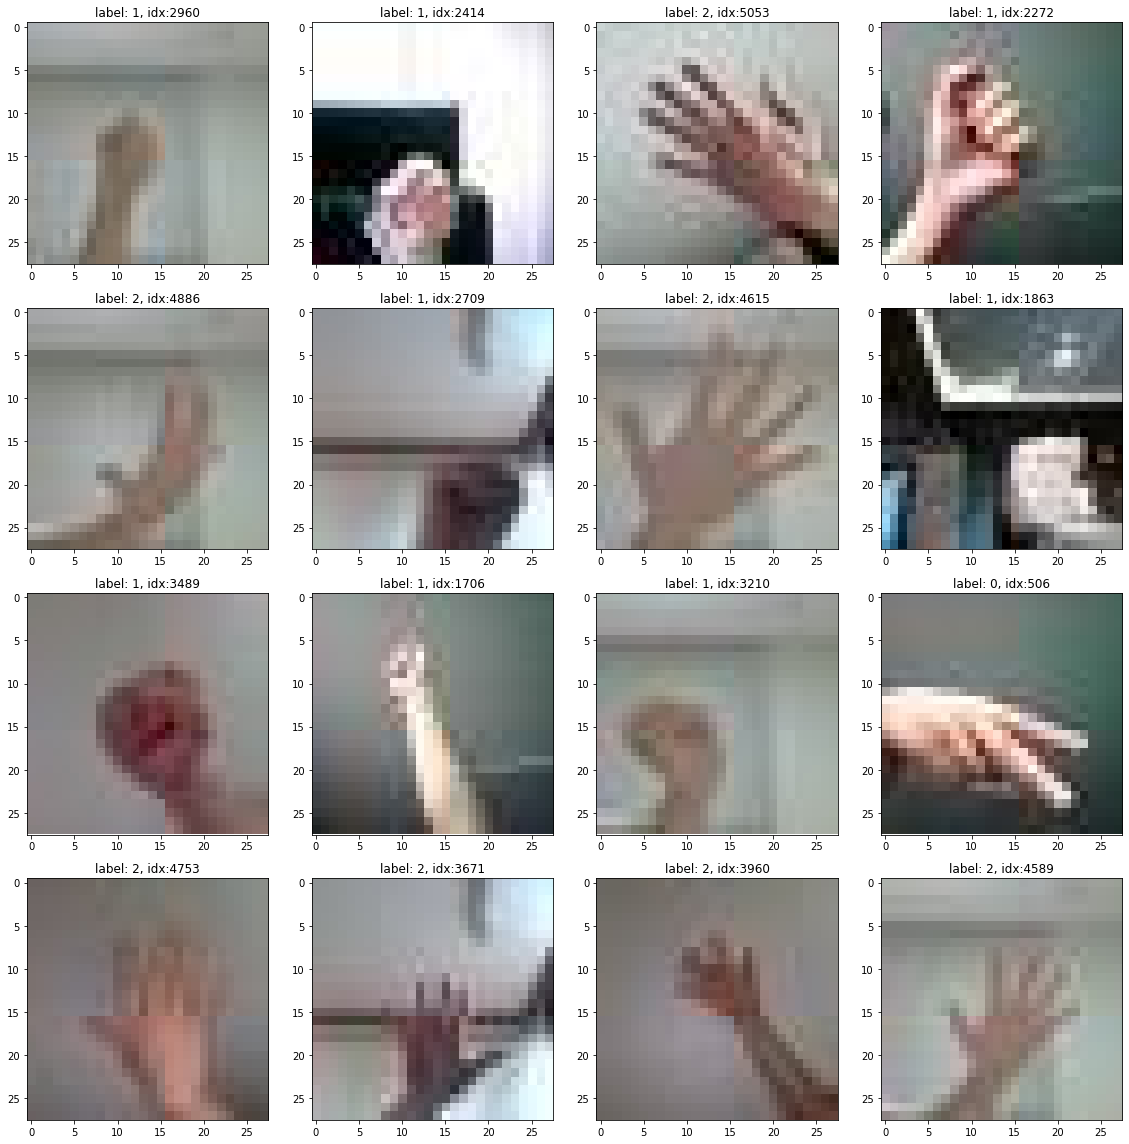

In [286]:
rng = np.random.default_rng()
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
axs = axes.ravel()
for i in range(16):
    idx = rng.integers(0, 5307)
    axs[i].imshow(x_train[idx])
    axs[i].set_title(f'label: {y_train[idx]}, idx:{idx}')
fig.tight_layout()

### 모델 만들기

간단한 CNN 모델을 임의로 만들었습니다. 마지막에 Flatten() 대신에 GlobalAveragePooling을 사용해봤습니다.

In [404]:
model = keras.models.Sequential() 

model.add(tf.keras.Input(shape=x_train.shape[1:]))

model.add(keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(32, (1,1), activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(2,2)) 


model.add(keras.layers.Conv2D(32, (2,2), activation='relu', padding='same')) 
model.add(keras.layers.MaxPooling2D((2,2))) 

model.add(keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')) 
model.add(keras.layers.MaxPooling2D((2,2))) 
 
model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Dense(32, activation='relu')) 
model.add(keras.layers.Dense(3, activation='softmax')) 

Adam optimizer를 사용했습니다.

In [405]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)

In [406]:
model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [407]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_161 (Conv2D)          (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 7, 7, 8)           2312      
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 3, 3, 8)         

In [408]:
history = model.fit(x_train, y_train, epochs=25)

Epoch 1/25
166/166 [==============================] - 1s 5ms/step - loss: 2.8409 - accuracy: 0.3199
Epoch 2/25
166/166 [==============================] - 1s 4ms/step - loss: 1.0538 - accuracy: 0.4163
Epoch 3/25
166/166 [==============================] - 1s 4ms/step - loss: 0.9767 - accuracy: 0.5096
Epoch 4/25
166/166 [==============================] - 1s 4ms/step - loss: 0.8435 - accuracy: 0.5988
Epoch 5/25
166/166 [==============================] - 1s 4ms/step - loss: 0.7537 - accuracy: 0.6476
Epoch 6/25
166/166 [==============================] - 1s 4ms/step - loss: 0.6896 - accuracy: 0.6871
Epoch 7/25
166/166 [==============================] - 1s 4ms/step - loss: 0.7056 - accuracy: 0.6836
Epoch 8/25
166/166 [==============================] - 1s 4ms/step - loss: 0.6136 - accuracy: 0.7340
Epoch 9/25
166/166 [==============================] - 1s 4ms/step - loss: 0.5319 - accuracy: 0.7820
Epoch 10/25
166/166 [==============================] - 1s 4ms/step - loss: 0.4948 - accuracy: 0.7910

트레인 데이터에 대해서는 96%의 정확도를 보이며 거의 모든 이미지를 다 맞추고 있습니다.

### 테스트 데이터 준비

In [409]:
t_s_image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data/test/scissors"
resize_images(t_s_image_dir_path)

print("테스트 가위 이미지 resize 완료!")

109  images to be resized.
109  images resized.
테스트 가위 이미지 resize 완료!


In [410]:
t_r_image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data/test/rock"
resize_images(t_r_image_dir_path)

print("테스트 바위 이미지 resize 완료!")

109  images to be resized.
109  images resized.
테스트 바위 이미지 resize 완료!


In [411]:
t_p_image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data/test/paper"
resize_images(t_p_image_dir_path)

print("테스트 보 이미지 resize 완료!")

109  images to be resized.
109  images resized.
테스트 보 이미지 resize 완료!


In [412]:
image_dir_path = os.getenv("HOME") + "/aiffel/rsp-data/test"
(x_test, y_test)=load_data(image_dir_path, 327)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 327 입니다.
x_test shape: (327, 28, 28, 3)
y_test shape: (327,)


### 테스트 결과 확인

In [413]:
model.evaluate(x_test, y_test)

11/11 [==============================] - 0s 2ms/step - loss: 1.7091 - accuracy: 0.6116


[1.7091236114501953, 0.6116207838058472]

훈련 정확도가 96%에 가까이 나오는 반면에, 예측 정확도는 60%정도가 겨우 나온다. 60%면 그다지 만족스럽지는 않은 결과이다. 아래 그림을 통해 예측에 대해 살펴보자.

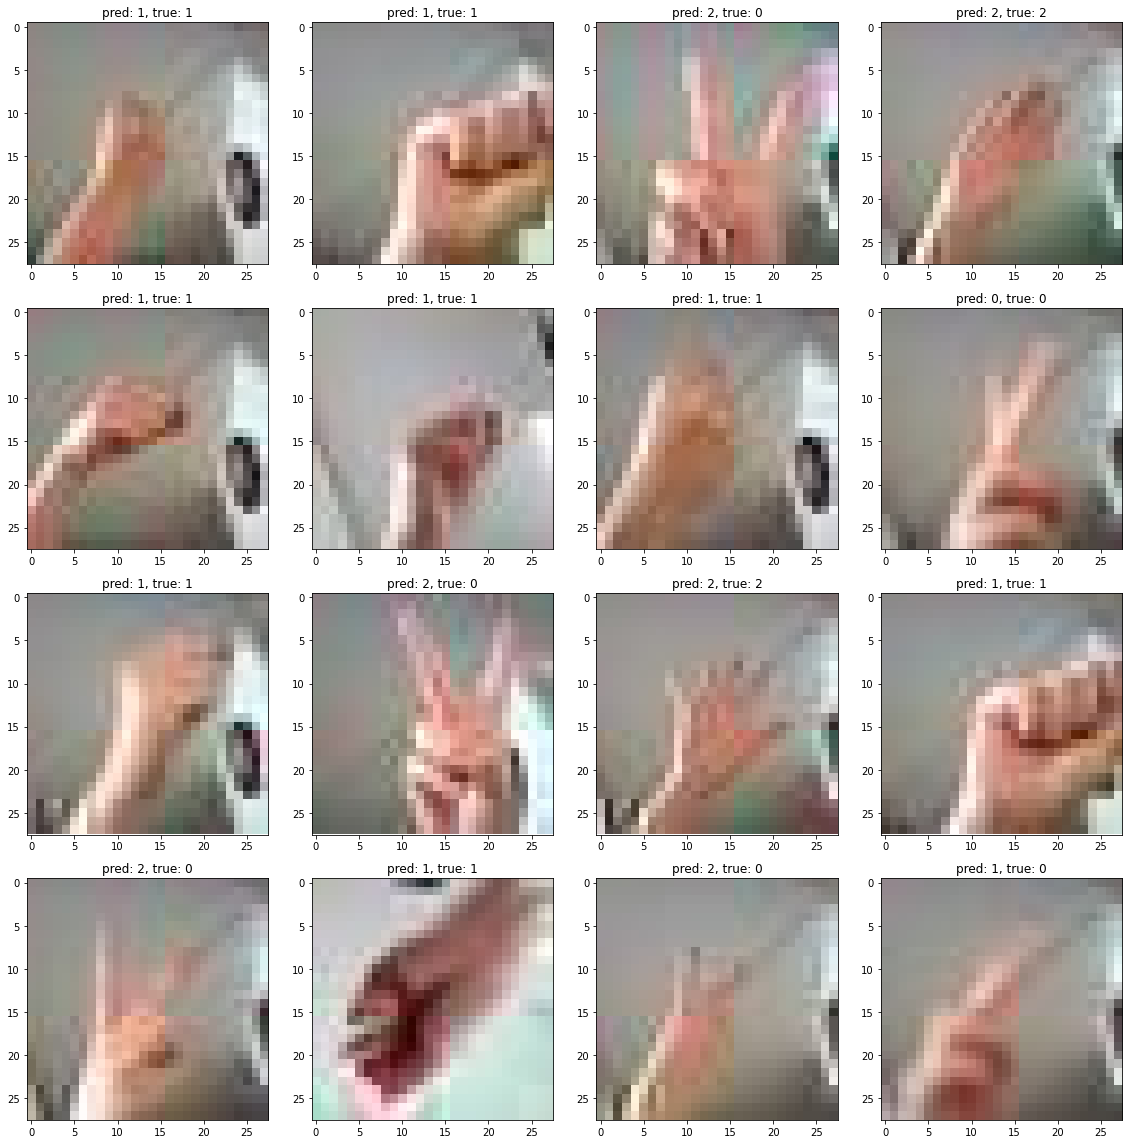

In [414]:
pred = model.predict(x_test)

import matplotlib.pyplot as plt
rng = np.random.default_rng()
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
axs = axes.ravel()
for i in range(16):
    idx = rng.integers(0, 284)
    axs[i].imshow(x_test[idx])
    axs[i].set_title(f'pred: {np.argmax(pred[idx])}, true: {y_test[idx]}')
fig.tight_layout()

트레이닝 셋의 이미지와 비슷하게 생겨도 컴퓨터가 인식하기에는 별도의 분포에서 뽑혔기 때문에 성능이 그다지 좋지 않다.
따라서 데이터셋의 구성을 별도의 트레이닝/테스트 셋으로 구성하기 보다는 하나의 셋에서 트레이닝/테스트 셋으로 분리하는 것이 더 좋다.

### 소감

#### 오버피팅 vs 언더피팅
훈련 정확도는 96퍼센트인 반면 테스트 정확도는 60퍼센트이니 오버피팅 문제이다. 따라서 오버피팅 문제를 해결하기 위해 비교적 간단한 형태의 모델을 만들어보기도 했고, 에폭 수를 줄이거나 별도의 Callback을 사용해보기도 했다. 하지만 어느정도 개선이 된다고 해도 눈에 띄게 개선이 되지는 않았다. 오버피팅 문제를 해결하기 위해 훈련 정확도를 낮춰보려는 시도는 오히려 언더피팅 문제를 만들었고 결국에는 테스트 정확도를 60% 정도 맞추는 데에 만족했다.
#### 데이터셋 구성
사실 노트북에는 작성되있지 않지만 성능을 올린 방법이 있었다. 작성을 하지 않은 이유는 올바른 학습 방법도 아니고 그냥 확인차 해본 실험이기 때문이였다. 성능을 올린 방법은 테스트 셋의 약 10장 정도를 임의로 훈련 셋에 넣었더니 성능이 크게 상승했다. 이는 무엇보다 학습을 하면서 그 테스트 데이터를 봤기 때문으로 보인다.

결과적으로 이러한 분류 문제가 풀기 힘들었던 이유는 훈련/테스트 셋을 별도로 만들었기 때문이다. 우리 눈에는 같아보여도 둘은 결국 다른 분포에서 왔다고 볼 수 있고 이는 통계적으로나(i.i.d) 문제를 정의하는 다양한 관점에서 문제가 있다. 따라서 올바른 풀이는 하나의 큰 이미지 세트에서 훈련/테스트 셋으로 분류를 하는 것으로 시작해야 한다.

끽해야 6000장 정도 되는 훈련 데이터다. 만약 데이터가 10배 정도 더 많았다면, MNIST만큼 60000장만 됐어도 충분히 보지 못한 테스트 셋에 대해서도 잘 맞출 수 있지 않았을까 하는 생각이 든다.
#### 더 해보고 싶은 것
1. Noisy Labeling
처음에는 훈련 정확도도 85%정도 밖에 나오지 않았다. 사실 비교적 간단한 데이터라 무조건 95%를 상회해야 한다고 생각했는데, 이유를 밤새 살펴보니 애초에 데이터셋에 잘못 라벨링 된 데이터가 있었다. 허무하기도 했지만 놀라운 건 잘못된 데이터가 있어도 사실 85%, 운이 좋으면 88, 89% 까지 성능이 나오는 건 나름 괜찮은 상황이라는 생각이 들었다. 그래서 잘못 라벨링된 데이터에 관한 논문을 몇개 찾아 읽어보기로 했다.
2. More Data
일단은 Kaggle 등에 가위바위보 데이터셋이 별도로 존재하는 것을 봤다. 따라서 이러한 데이터를 더 추가해 보지 못한 테스트 이미지에 대한 성능을 가능한 높이 올려보는 것에도 도전을 해봐야겠다.